# 1-D finite rate chemistry for dissociating air -Arrhenius.jl

Add the necessary packages. Arrhenius.jl being the primary package (analogous to cantera, except more Julia-exploitable)

In [74]:
using Arrhenius
using LinearAlgebra
using DifferentialEquations
using ForwardDiff
using DiffEqSensitivity
using Sundials
using Plots
using DelimitedFiles
using Profile
using PyCall

In [88]:
ct = pyimport("cantera")
gas = CreateSolution("../../mechanism/air.yaml")
# gas = ct.Solution("airNASA9.yaml")
ns = gas.n_species

8

In [89]:
gas.species_names

8-element Vector{String}:
 "O"
 "O2"
 "N"
 "NO"
 "NO2"
 "N2O"
 "N2"
 "AR"

In [91]:
Y0 = zeros(ns)
Y0[species_index(gas, "N2")] = 0.76
Y0[species_index(gas, "O2")] = 0.24
T0 = 7000.0
P = 0.001*one_atm
u0 = vcat(Y0, T0)

9-element Vector{Float64}:
    0.0
    0.24
    0.0
    0.0
    0.0
    0.0
    0.76
    0.0
 7000.0

In [94]:
#setup the function 
u0 = vcat(Y0, T0)
@inbounds function dudt!(du, u, p, t)
    T = u[end]
    Y = @view(u[1:ns])
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
#     mean_MW = 1. / dot(Y, 1 ./ gas.molecular_weights)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

dudt! (generic function with 1 method)

In [95]:
#solve the ODE problem
xspan = [0.05, 0.15];
prob = ODEProblem(dudt!, u0, xspan);
sol = solve(prob, TRBDF2(), reltol=1e-6, abstol=1e-9)

retcode: Success
Interpolation: 3rd order Hermite
t: 32-element Vector{Float64}:
 0.05
 0.05000002264756582
 0.050000249123224004
 0.05000251387980583
 0.050025161445624106
 0.05007467109945963
 0.05014340165821382
 0.05028421351442785
 0.05042502537064188
 0.050688234159944126
 0.050951442949246376
 0.05141797191134519
 0.051884500873444
 ⋮
 0.06379747900023046
 0.0670014851783099
 0.07042417728834513
 0.07583098077864259
 0.0812792296560188
 0.08906325838485041
 0.09684728711368201
 0.1073147012376127
 0.1177821153615434
 0.13117942646321124
 0.14457673756487907
 0.15
u: 32-element Vector{Vector{Float64}}:
 [0.0, 0.24, 0.0, 0.0, 0.0, 0.0, 0.76, 0.0, 7000.0]
 [5.79454301194248e-7, 0.2399994110784422, 4.42481533723793e-12, 9.481552130405966e-12, 4.5042198959592335e-18, 2.6030367945489556e-8, 0.7599999834229823, 0.0, 6999.983345646818]
 [6.372815783035913e-6, 0.2399935224985275, 5.345697025103509e-10, 1.148512232294154e-9, 5.6598508781325206e-15, 2.8630404622570683e-7, 0.759999816698555

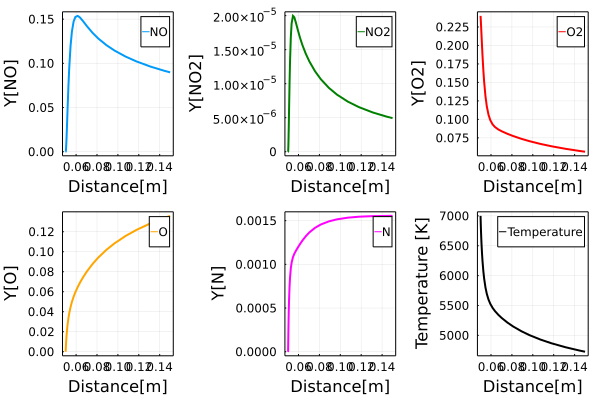

In [99]:
plt = plot(sol.t, sol[species_index(gas, "NO"), :], lw=2, label="NO");
ylabel!(plt, "Y[NO]")
plt1 = plot(sol.t, sol[species_index(gas, "NO2"), :], lw=2, linecolor = "green", label="NO2");
ylabel!(plt1, "Y[NO2]")
plt2 = plot(sol.t, sol[species_index(gas, "O2"), :], lw=2, linecolor = "red", label="O2");
ylabel!(plt2, "Y[O2]")
plt3 = plot(sol.t, sol[species_index(gas, "O"), :], lw=2, linecolor = "orange", label="O");
ylabel!(plt3, "Y[O]")
plt4 = plot(sol.t, sol[species_index(gas, "N"), :], lw=2, linecolor = "magenta", label="N");
ylabel!(plt4, "Y[N]")
pltT = plot(sol.t, sol[end, :], lw=2, label="Temperature", linecolor="black");
ylabel!(pltT, "Temperature [K]")
xlabel!(pltT, "Distance[m]")
# title!(plt, "Air Dissociation 1-D finite rate chemistry")
pltsum = plot(plt, plt1, plt2, plt3, plt4,pltT, legend=true, framestyle=:box)
xlabel!(pltsum,"Distance[m]")
# png(pltsum, "JP10_pyrolysis.png")

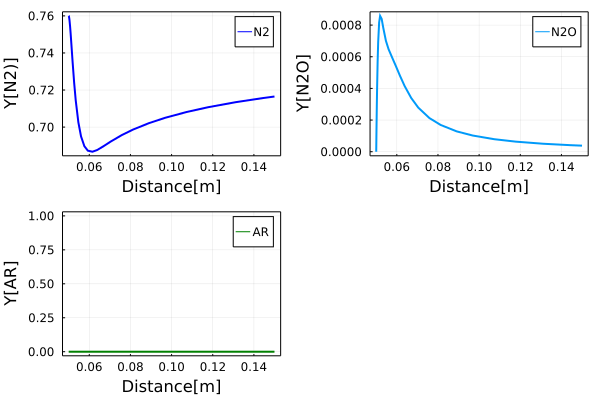

In [98]:
plt5 = plot(sol.t, sol[species_index(gas, "N2"), :], lw=2, linecolor = "blue", label="N2");
ylabel!(plt5, "Y[N2)]")
plt6 = plot(sol.t, sol[species_index(gas, "N2O"), :], lw=2, label="N2O");
ylabel!(plt6, "Y[N2O]")
# title!(plt, "Air Dissociation 1-D finite rate chemistry")
pltsum = plot(plt5, plt6, plt7,legend=true, framestyle=:box)
xlabel!(pltsum,"Distance[m]")